# Visualization for Inventory Analysis  

## Thêm thư viện và lấy key

In [12]:
import psycopg2
import pyodbc
import sys
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from config import table_names, columns_name, parse_dates_columns
from sqlalchemy import create_engine
server = os.environ['SQLSERVER'] 
database = os.environ['SQLDATABASE']  
username = os.environ['SQLUID'] 
password = os.environ['SQLPWD'] 

## Load dữ liệu từ SQL Server

In [13]:
engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')
query = """SELECT * FROM Dim_Vendor"""
dim_vendor = pd.read_sql_query(query, engine)
print("Load thành công bảng dim_vendor")

query = """SELECT * FROM Dim_Product"""
dim_product = pd.read_sql_query(query, engine)
print("Load thành công bảng dim_product")

query = """SELECT * FROM Dim_Inventory"""
dim_inventory = pd.read_sql_query(query, engine)
print("Load thành công bảng dim_inventory")

query = """SELECT * FROM Dim_Sales_Date"""
dim_sales_date = pd.read_sql_query(query, engine)
print("Load thành công bảng dim_sales_date")

query = """SELECT * FROM Sales_Fact_Table"""
sales_fact_table = pd.read_sql_query(query, engine)
print("Load thành công bảng sales_fact_table")

query = """SELECT * FROM Dim_Purchase_Orders"""
dim_purchase_order = pd.read_sql_query(query, engine)
print("Load thành công bảng dim_purchase_order")

query = """SELECT * FROM Purchases_Fact_Table"""
purchases_fact_table = pd.read_sql_query(query, engine)
print("Load thành công bảng purchases_fact_table")

Load thành công bảng dim_vendor
Load thành công bảng dim_product
Load thành công bảng dim_inventory
Load thành công bảng dim_sales_date
Load thành công bảng sales_fact_table
Load thành công bảng dim_purchase_order
Load thành công bảng purchases_fact_table


### Thông tin về bảng Sales

In [14]:
sales_fact_table.head()

,Inventory_Id,Sales_date,Sales_dollar,Sales_price,Sales_quantity,Excise_tax
0,1_HARDERSFIELD_1004 ...,2016-01-01,16.49,16.49,1,0.79
1,1_HARDERSFIELD_1004 ...,2016-01-02,32.98,16.49,2,1.57
2,1_HARDERSFIELD_1004 ...,2016-01-03,16.49,16.49,1,0.79
3,1_HARDERSFIELD_1004 ...,2016-01-08,14.49,14.49,1,0.79
4,1_HARDERSFIELD_1005 ...,2016-01-09,69.98,34.99,2,0.79


### Thông tin về bảng Purchase

In [15]:
purchases_fact_table.head()

,PONumber,Inventory_Id,Purchase_quantity,Purchase_dollar,Receiving_date
0,8124,69_MOUNTMEND_8412 ...,6,214,2016-01-02
1,8137,30_CULCHETH_5255 ...,4,37,2016-01-01
2,8137,34_PITMERDEN_5215 ...,5,47,2016-01-02
3,8137,1_HARDERSFIELD_5255 ...,6,56,2016-01-01
4,8169,76_DONCASTER_2034 ...,5,106,2016-01-02


## Phân tích sales theo thời gian

<Axes: title={'center': 'Sales Quantity Over Time'}, xlabel='Sales_date'>

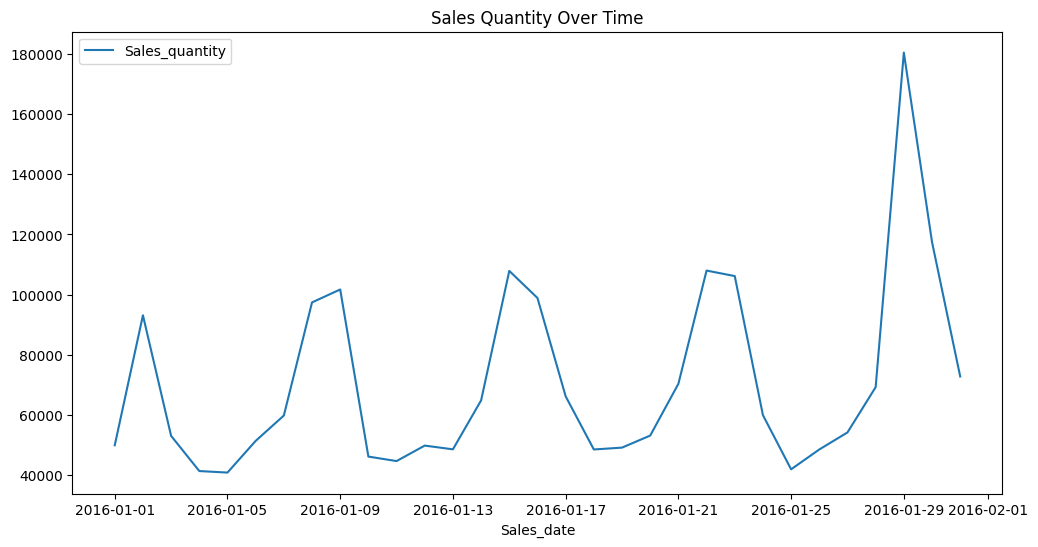

In [16]:
sales_quantity_trend = sales_fact_table.groupby('Sales_date').agg({'Sales_quantity': 'sum'})
sales_quantity_trend.plot(figsize=(12, 6), title='Sales Quantity Over Time')

<Axes: title={'center': 'Average Sales Price Over Time'}, xlabel='Sales_date'>

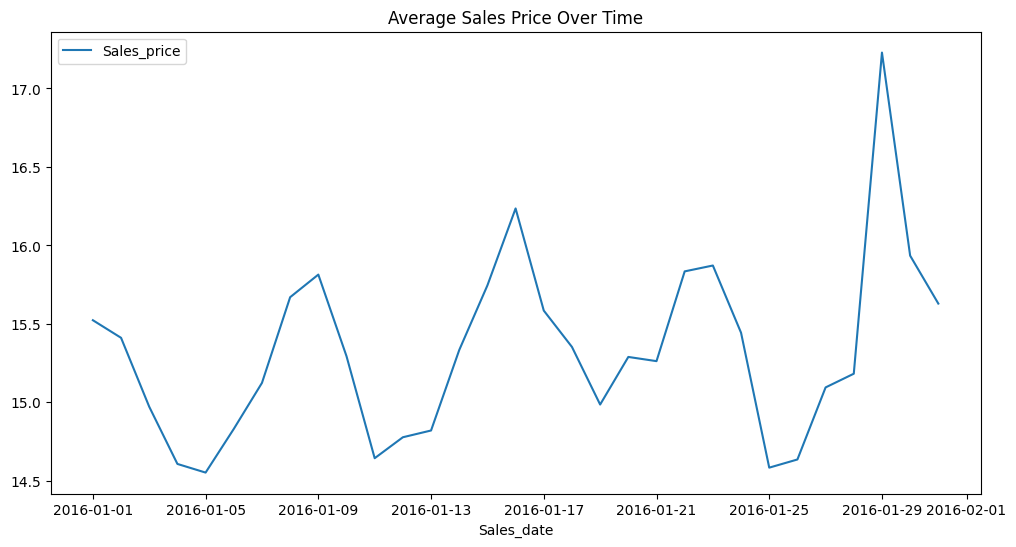

In [17]:
avg_price_trend = sales_fact_table.groupby('Sales_date').agg({'Sales_price': 'mean'})
avg_price_trend.plot(figsize=(12, 6), title='Average Sales Price Over Time')


Dựa vào biểu đồ ta thấy xu hướng bán hàng có tính chất hàng tuần, nhờ vậy ta có thể sử dụng các mô hình hoặc phương pháp phổ biến để phân tích và dự đoán xu hường hằng tuần.


## Phân tích mua hàng

### Tìm hiểu xem đâu là nhà phân phối được đầu tư nhiều?

In [18]:
temp = (purchases_fact_table['Purchase_dollar'] * purchases_fact_table['Purchase_quantity'])
df = {"inventory_id": purchases_fact_table['Inventory_Id'].values, "total_cost": temp.values}
cost_dollar =  pd.DataFrame(df)
cost_dollar = pd.merge(cost_dollar, dim_inventory, left_on='inventory_id', right_on='Inventory_Id', how='inner').drop(['Inventory_Id','City','Store'], axis=1)
cost_dollar_1 = pd.merge(cost_dollar, dim_product, on='Brand', how='inner').drop(['Description','Price','Purchase_price','Size', 'Volume'], axis=1)
cost_dollar_2 = pd.merge(cost_dollar_1, dim_vendor, on='Vendor_no', how='inner')
cost_by_vendor = cost_dollar_2.groupby('Vendor_name')['total_cost'].sum().reset_index().sort_values('total_cost', ascending=False)
cost_by_vendor.Vendor_name = cost_by_vendor.Vendor_name.str.strip()
cost_by_vendor.head()

,Vendor_name,total_cost
28,DIAGEO NORTH AMERICA INC,2878703090
8,BACARDI USA INC,1796227395
73,PERNOD RICARD USA,1292788303
62,MARTIGNETTI COMPANIES,1177950578
49,JIM BEAM BRANDS COMPANY,898090455


In [19]:
cost_by_vendor.sort_values('total_cost', ascending=False).head(10)

,Vendor_name,total_cost
28,DIAGEO NORTH AMERICA INC,2878703090
8,BACARDI USA INC,1796227395
73,PERNOD RICARD USA,1292788303
62,MARTIGNETTI COMPANIES,1177950578
49,JIM BEAM BRANDS COMPANY,898090455
14,BROWN-FORMAN CORP,883995618
66,MOET HENNESSY USA INC,512448811
23,CONSTELLATION BRANDS INC,457952634
58,M S WALKER INC,404575004
112,ULTRA BEVERAGE COMPANY LLP,384564749


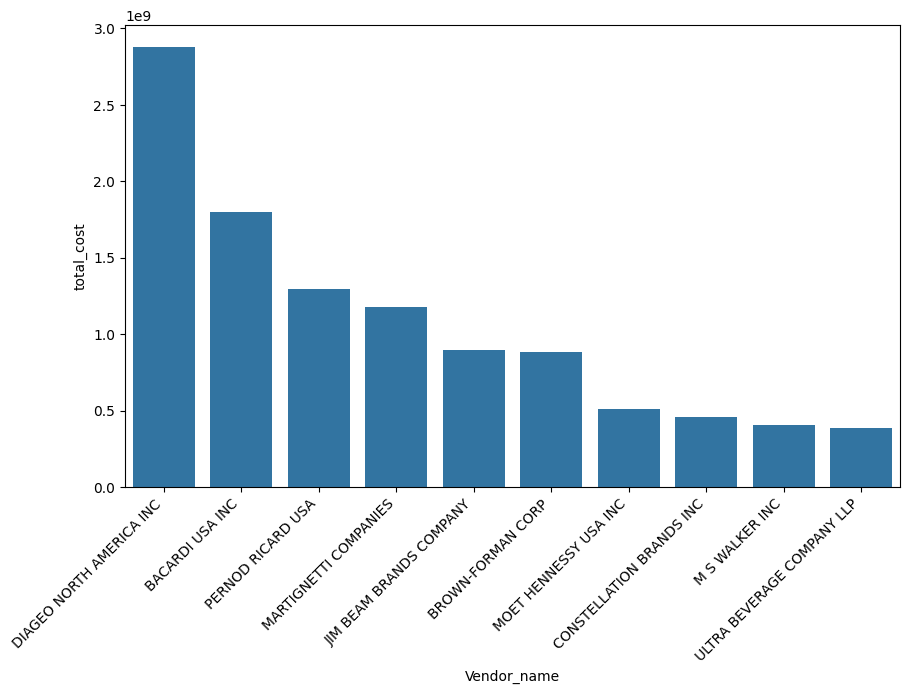

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(data=cost_by_vendor.head(10), x='Vendor_name', y='total_cost')
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()

Ta tiến hành so sánh phần trăm chi phí mua hàng giữa các nhà phân phối trong top 10:

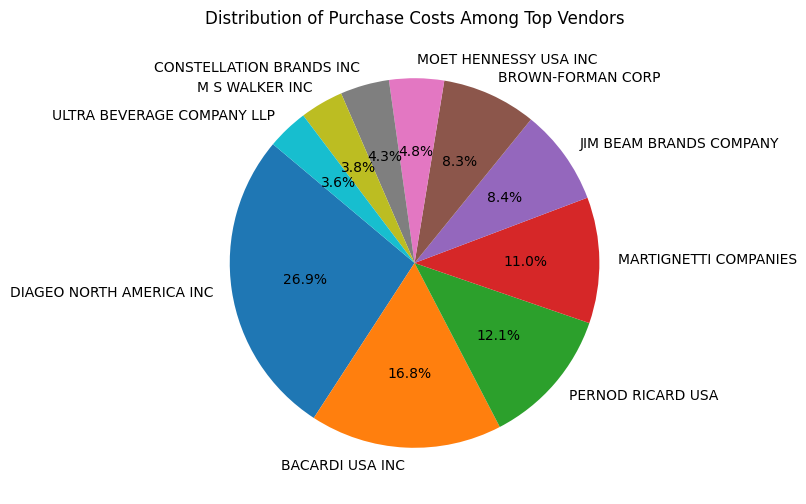

In [21]:
plt.figure(figsize=(10, 6))
plt.pie(cost_by_vendor.head(10)['total_cost'],autopct='%1.1f%%', startangle=140, labels = cost_by_vendor.head(10)['Vendor_name'])
# cost_by_vendor.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Purchase Costs Among Top Vendors')
plt.ylabel('')  # to remove the default 'PurchasePrice' label from the y-axis
plt.show()

Từ biểu đồ tròn cho ta thấy top 10 nhà cung cấp dựa theo chi phí mua hàng. Ta có thể thấy rõ ràng DIAGEO NORTH AMERICA INC chiếm ưu thể mạnh khi chiếm hơn 1/4 tổng chi phí của top 10 nhà phân phối.

### Tìm hiểu đâu là sản phẩm được ưa chuộng? 

In [22]:
sales_velocity = sales_fact_table.groupby('Inventory_Id').agg(Total_sales =('Sales_quantity','sum')).reset_index()
sales_velocity = pd.merge(sales_velocity, dim_inventory[['Inventory_Id','Brand']], on='Inventory_Id', how='inner')
sales_velocity = pd.merge(sales_velocity, dim_product[['Brand', 'Description']], on='Brand', how='inner')
sales_velocity['Description'] = sales_velocity['Description'].str.strip()
sales_velocity = sales_velocity.groupby('Description')['Total_sales'].sum().reset_index()
total_days = (sales_fact_table['Sales_date'].max() - sales_fact_table['Sales_date'].min()).days
sales_velocity['Sales_per_day'] = sales_velocity['Total_sales'] / total_days

In [23]:
sales_velocity.sort_values(by='Sales_per_day', ascending=False).head(20)   

,Description,Total_sales,Sales_per_day
5746,Smirnoff 80 Proof,39742,1324.733333
1116,Capt Morgan Spiced Rum,31942,1064.733333
2240,Dr McGillicuddy's Mentholmnt,22138,737.933333
6762,Yukon Jack,21465,715.500000
3300,Jack Daniels No 7 Black,21004,700.133333
72,Absolut 80 Proof,20282,676.066667
5765,Smirnoff Raspberry Vodka,20114,670.466667
3422,Jim Beam,19162,638.733333
6303,Tito's Handmade Vodka,17825,594.166667
1047,Canadian Club,16768,558.933333


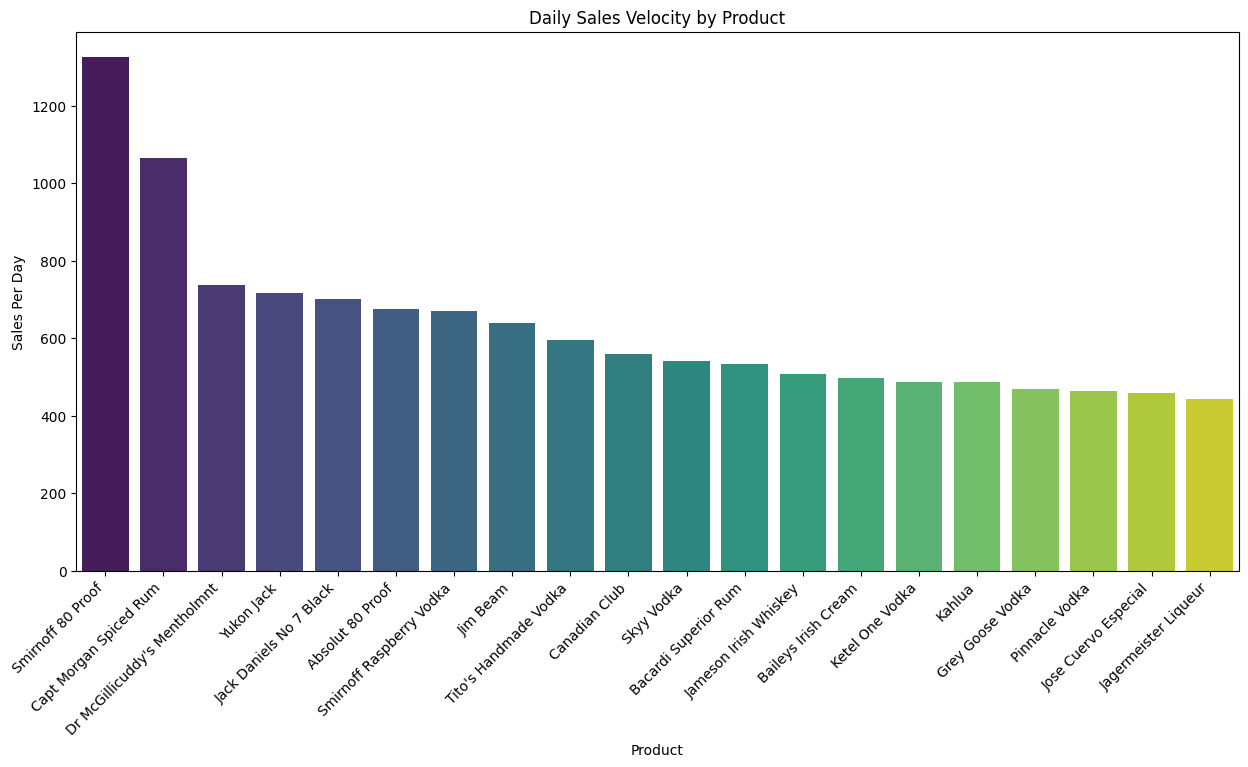

In [24]:
# Sorting the data by Sales_Per_Day in descending order to get top products
top_products = sales_velocity.sort_values(by='Sales_per_day', ascending=False).head(20)  # you can adjust the number as needed

# Creating the bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='Description', y='Sales_per_day', hue='Description', data=top_products, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Daily Sales Velocity by Product')
plt.xlabel('Product')
plt.ylabel('Sales Per Day')
plt.show()

In [25]:
sales_revenue = sales_fact_table.groupby('Inventory_Id').agg(Total_sales =('Sales_dollar','sum')).reset_index()
sales_revenue = pd.merge(sales_revenue, dim_inventory[['Inventory_Id','Brand']], on='Inventory_Id', how='inner')
sales_revenue = pd.merge(sales_revenue, dim_product[['Brand', 'Description']], on='Brand', how='inner')
sales_revenue['Description'] = sales_revenue['Description'].str.strip()
sales_revenue = sales_revenue.groupby('Description')['Total_sales'].sum().reset_index()
sales_revenue.head()

,Description,Total_sales
0,(RI) 1,1395.62
1,10 Span Cab Svgn CC,89.88
2,10 Span Chard CC,539.28
3,10 Span Pnt Nr CC,232.19
4,12 Days of Pearls Gift Set,249.75


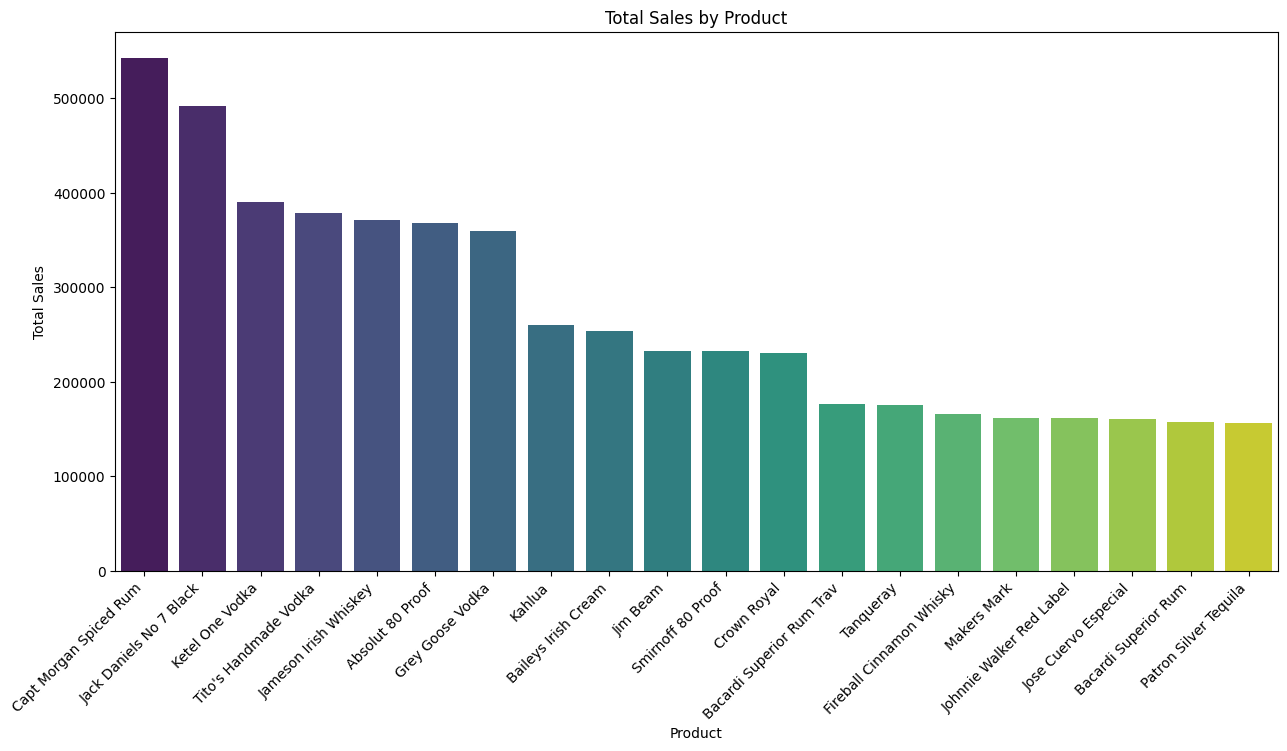

In [26]:
top_products_by_dollar = sales_revenue.sort_values(by='Total_sales', ascending=False).head(20)  # you can adjust the number as needed

# Creating the bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='Description', y='Total_sales', hue='Description', data=top_products_by_dollar, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Total Sales by Product')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.show()

Tuy rằng ở biểu đồ số lượng bán theo ngày, **Smirnoff 80 Proof** đứng đầu về số lượng bán nhưng về doanh thu thì chỉ đứng thứ 11.
Vậy nên sản phẩm được xem là ưa chuộng nhất trong tháng 1 này chính là **Capt Morgan Spiced Rum** khi nó đã dẫn đầu về doanh thu và đứng thứ 2 về số lượng bán được, ta có thể xem như đây là một **sản phẩm chiến lược**.
Và theo sau đó là **Jack Daniels No 7 Black** với doanh thu đứng thứ 2 và doanh số đứng thứ 5. 